In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR = 0.03
EPS = 1e-8

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            action_space = _q_batch_tgt.shape[1]
            done_mask = torch.cat(tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        q_np = q.cpu().numpy()[0]
    action = np.argmax(q_np)

    return action

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
epsilon_decay = False
# update_frq = int(env.spec.timestep_limit/10)
update_frq = 1
epsilon = 1.
eps_min = 0.005
eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
# optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=LR, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

200

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
env.spec.timestep_limit

200

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < eps_min:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
#         epsilon -= epsilon * eps_decay
#         epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00

============  Start Learning  ============

  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00
  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3530 steps, reward -130.00
 19 Episode in  3730 steps, reward -200.00
 20 Episode in  3930 steps, reward -200.00
 21 Episode in  4060 steps, reward -130.00
 22 Episode in  4189 steps, reward -129.00
 23 Episo

191 Episode in 36979 steps, reward -200.00
192 Episode in 37179 steps, reward -200.00
193 Episode in 37379 steps, reward -200.00
194 Episode in 37579 steps, reward -200.00
195 Episode in 37779 steps, reward -200.00
196 Episode in 37946 steps, reward -167.00
197 Episode in 38146 steps, reward -200.00
198 Episode in 38346 steps, reward -200.00
199 Episode in 38546 steps, reward -200.00
200 Episode in 38746 steps, reward -200.00


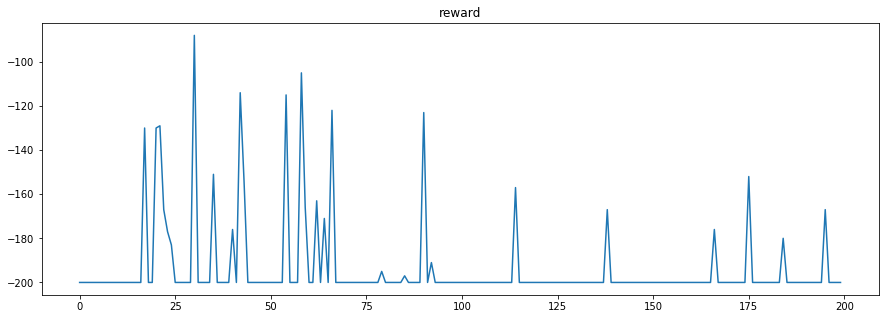

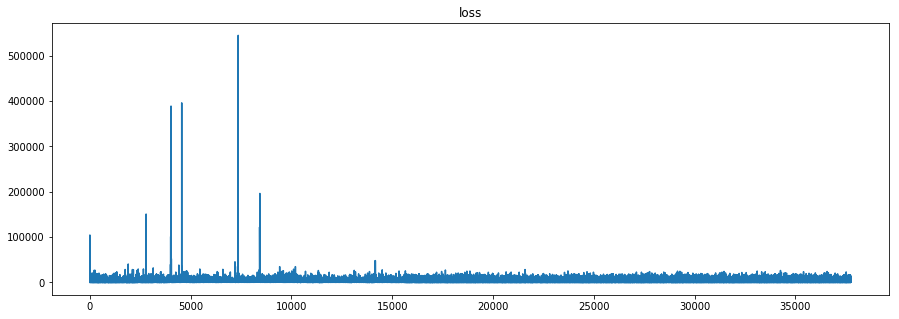

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()